<H1><center>Earthquake predictions in Mexico<br>(Pre-processing & Training Data Development)</center></H1>

In the previous steps we were able to identify some important information about our data. Basically we identified the following&colon;<br><br>
&nbsp;&nbsp;&nbsp;a) Stronger earthquakes in magnitude, occur (in general) closer to the surface (lower value of depth)<br>
&nbsp;&nbsp;&nbsp;b) By analyzing different years where a big event occurred, we could identify similar patterns where magnitude in events throughout the year was increasing slowly until the main earthquake happened<br>
&nbsp;&nbsp;&nbsp;c) There is a tendency that the bigger earthquakes take place around the last quarter of the year<br>
&nbsp;&nbsp;&nbsp;d) Location is very important due to the proximity to tectonic plates (pacific coast). It should be interesting to add a feature considering these plates<br>
&nbsp;&nbsp;&nbsp;e) When comparing areas (states) with high seismic activity, we were able to identify specifically which ones were the ones with the highest frequency of events<br>

Now we will focus in adding any other features that may seem to give value to the model we are going to train. Since the goal of this project is to try to estimate the time-to-event, we are going to handle it as a survival analysis. Due to this, we will need two columns in our 'y' set, as follows&colon;<br><br>
&nbsp;&nbsp;&nbsp;a) The 'status' binary categorical column indicating the presence of the event. We will consider any event of magnitude greater than or equal to 6.0 as '1' and any other event as '0'<br>
&nbsp;&nbsp;&nbsp;b) The 'survival in days' numerical (continuous) column indicating the time passed until the event happened. For this part, we will need to think about how are we going to consider the starting point to calculate the time for every event. Since this is no ordinary use for the survival analysis, we will try to adapt our case to it. Later in this notebook we will explain how we considered the time-to-event values.

In [1]:
#First, we import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from library.sb_utils import save_file
import warnings
warnings.filterwarnings('ignore')

In [2]:
quakes_data = pd.read_csv('../derived_data/quakes_data_cleaned.csv')
quakes_data.drop(columns=['Unnamed: 0'], inplace=True)
quakes_data['Date_Time'] = pd.to_datetime(quakes_data.Date_Time)
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,Location reference,State
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,"141 km al SUR de SAN MARCOS, GRO",GRO
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,"62 km al SUROESTE de CD HIDALGO, CHIS",CHIS
2,1970-04-30 02:32:58,1970,4,30,6.5,14.608,-93.260,22.0,"100 km al SUROESTE de MAPASTEPEC, CHIS",CHIS
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,"92 km al SUROESTE de PUEBLO YAQUI, SON",SON
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,"238 km al OESTE de CIHUATLAN, JAL",JAL


Let's take a look again at our data's shape.

In [3]:
quakes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39937 entries, 0 to 39936
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_Time           39937 non-null  datetime64[ns]
 1   Year                39937 non-null  int64         
 2   Month               39937 non-null  int64         
 3   Day                 39937 non-null  int64         
 4   Magnitude           39937 non-null  float64       
 5   Latitude            39937 non-null  float64       
 6   Longitude           39937 non-null  float64       
 7   Depth               39937 non-null  float64       
 8   Location reference  39937 non-null  object        
 9   State               39937 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 3.0+ MB


We have at the moment 10 features and we will need to add at least two more columns for our label variable 'y'. We will call these columns as 'Status' and 'Time_to_event'. But before that, let's drop 'Location reference' column since it is not going to add any value to our model. All the information we will use for the model, in terms of location reference, we have it in the 'State' feature.

In [4]:
quakes_data.drop(columns=['Location reference'], inplace=True)

In [5]:
#We pass a '1' to all the events with greater or equal magnitude of 6.0. Pass '0' to any other event
quakes_data['Status'] = 1
quakes_data.loc[quakes_data['Magnitude'] < 6.0, 'Status'] = 0
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Status
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,1
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,1
2,1970-04-30 02:32:58,1970,4,30,6.5,14.608,-93.260,22.0,CHIS,1
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,1
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,1


We added that 'Status' column and now we will have to do some preparation to add the 'Time_to_event' column. We need to define first our starting date. This date is going to be the oldest date in our dataset.

In [6]:
#Let's define our start date to calculate times to event.
start_date = quakes_data.iloc[0,0]
start_date

Timestamp('1970-02-03 23:08:50')

Now we are going to create the column with an initial value which will be the difference between the row's date and the start date. This value will be a float indicating the total seconds of the dates' differences.

In [7]:
quakes_data['Time_to_event'] = quakes_data['Date_Time'].diff()
quakes_data['Time_to_event'] = quakes_data['Time_to_event'].apply(lambda x: x.total_seconds())
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,1,NaN
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,1,7289564.0
2,1970-04-30 02:32:58,1970,4,30,6.5,14.608,-93.260,22.0,CHIS,1,66684.0
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,1,44754302.0
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,1,33350386.0


As we can see, the first row indicates a null value. We will leave it as it is for now. 
At the moment, we calculated every value in the 'Time_to_event' column as a float in seconds of the difference in dates. We always considered the oldest date in the dataset as our starting point, but is this the best way to do this? Let's think about what we know up to this point. We know that location is very important in terms of the magnitude and frequency of events. Taking this into account, we may consider another way to calculate this column. 
We will do the following instead&colon;<br><br>
&nbsp;&nbsp;&nbsp;a) We will cluster the data based on the categories of the 'State' column. There are 31 categories, one for each state inlcuded in the data<br>
&nbsp;&nbsp;&nbsp;b) We will make the calculations for the times to event independent by each cluster<br>
&nbsp;&nbsp;&nbsp;c) We will also treat independently the calculations for events with 'Status' == 1 or 'Status' == 0<br>
&nbsp;&nbsp;&nbsp;d) Finally, the starting date for the first instance of every event on each class that we defined above, will be the oldest date. But our starting date will not be fixed. It means that every date will become the starting point for the next instance in the class and so on until the end of the dataset.<br><br>
Let's create a function to do all the calculations specified above. We may need to use it again in the future.

In [8]:
#We define the function to calculate the times to event. 
#We just need to pass the dataframe and our initial starting date.

def time_to_event_calculations(df, start_date):
    #Let's iterate over all the states. This way we can make the calculations for every state at a time.
    for state in df.State.unique():
        i = 0
        j = 0
        count_1 = 0
        count_2 = 0
        #Now we iterate for every row where the 'State' column matches our iterating state
        for index, row in df.loc[df['State'] == state].iterrows():
            #Now that we have the state class, we separate the calculation by status class (magnitude >=6.0 or <6.0)
            if row['Magnitude'] >= 6.0:
                if count_1 == 0:
                    #We calculate the time in the first iteration using the start_date as base
                    diff = row['Date_Time'] - start_date
                if count_1 != 0:
                    #For any subsequent calculation, we use the previous event in the class as the start_date
                    diff = row['Date_Time'] - df.loc[i, 'Date_Time']
                #We assign the calculation in seconds to the corresponding row in the df
                diff = diff.total_seconds()
                df.loc[index, 'Time_to_event'] = diff
                i = index
                count_1 = 1
            #We do the same for the status class of magnitude < 6.0
            if row['Magnitude'] < 6.0:
                if count_2 == 0:
                    diff = row['Date_Time'] - start_date
                if count_2 != 0:
                    diff = row['Date_Time'] - df.loc[j, 'Date_Time']
                diff = diff.total_seconds()
                df.loc[index, 'Time_to_event'] = diff
                j = index
                count_2 = 1
    return df

#We use the created function to make the calculations in seconds and assign them to the 'Time_to_event' column
quakes_data = time_to_event_calculations(quakes_data, start_date)
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,1,0.0
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,1,7289564.0
2,1970-04-30 02:32:58,1970,4,30,6.5,14.608,-93.260,22.0,CHIS,1,66684.0
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,1,52110550.0
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,1,85460936.0


According to what we stated previously, we have now the correct values for the 'Time_to_event' feature. But, if we look carefully at rows with index 1 and 2 of the dataframe shown above, we can see that both rows correspond to the same state and almost same latitude and longitude. If we check the value in 'Time_to_event' for row number 2, we see 66684 seconds (~0.77 days). This implies that this event is a foreshock of the first one. To try to avoide this 'duplicity' of information we will establish a threshold and eliminate rows with low values in 'Time_to_event'. First, let's check how many rows we find within different thresholds.

In [9]:
#Let's check rows for a threshold of 1 day and 7 days respectively
print('The number of rows with a value lower than 1 day is:', quakes_data.loc[quakes_data['Time_to_event'] < 86400]['Time_to_event'].count())
print('The number of rows with a value lower than 7 days is:', quakes_data.loc[quakes_data['Time_to_event'] <= 604800]['Time_to_event'].count())

The number of rows with a value lower than 1 day is: 23514
The number of rows with a value lower than 7 days is: 34906


As we can see, either threshold means dropping a lot of rows. For the sake of the exercise, we will use the 1-day threshold. Doing this also means that we will have to do the calculations again for the rows left. We expect that after this new calculation we don't have any times lower than 86400 seconds.

In [10]:
#Let's drop all rows with values less than 86400 seconds, except our start data which has a value of 0.
quakes_data.drop(quakes_data.loc[(quakes_data['Time_to_event'] <= 86400) & (quakes_data['Time_to_event'] > 0)].index, inplace = True)
quakes_data.shape

(16424, 11)

In [11]:
#Let's update the start date and check if it changed.
start_date = quakes_data.iloc[0,0]
start_date

Timestamp('1970-02-03 23:08:50')

In [12]:
#The start date is the same so we can proceed to make calculations again.
quakes_data = time_to_event_calculations(quakes_data, start_date)
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,1,0.0
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,1,7289564.0
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,1,52110550.0
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,1,85460936.0
5,1972-11-12 22:43:45,1972,11,12,6.5,15.541,-95.040,14.0,OAX,1,87521695.0


Now that we have our data ready, let's just change seconds for days in the 'Time_to_event' column.

In [13]:
quakes_data['Time_to_event'] = round(quakes_data['Time_to_event'] / 86400, 2)
quakes_data.reset_index(drop=True, inplace=True)
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,1,0.00
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,1,84.37
2,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,1,603.13
3,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,1,989.13
4,1972-11-12 22:43:45,1972,11,12,6.5,15.541,-95.040,14.0,OAX,1,1012.98


Finally, let's make another feature that we will use in our model. This feature will represent the proximity that each area (state) has with one of the four tectonic plates in Mexico. Since there are 4 plates, this feature will be categorical with 4 classes. Let's create this feature and include it in our dataframe.

In [14]:
#Let's create the four categories we will use for this new feature.
rivera = ['SIN', 'NAY', 'JAL']
cocos = ['COL', 'MICH', 'GRO', 'OAX', 'CHIS']
pacific = ['BC', 'BCS']
north_america = list(set(quakes_data['State'].values) - set(rivera + cocos + pacific))
print(north_america)

['YUC', 'NL', 'QR', 'TAB', 'TAMS', 'PUE', 'GTO', 'SLP', 'TLAX', 'COAH', 'CHIH', 'CAMP', 'VER', 'CDMX', 'ZAC', 'MOR', 'SON', 'DGO', 'QRO', 'MEX', 'HGO']


In [15]:
#Now let's create the new feature and assign its corresponding value based on the categories.
quakes_data.insert(9, 'Plate', '')
plates_list = [rivera, cocos, pacific, north_america]
plates_categories = ['rivera', 'cocos', 'pacific', 'north_america']
for i in range(len(plates_list)):
    quakes_data['Plate'] = np.where((quakes_data.State.isin(plates_list[i])), plates_categories[i],quakes_data.Plate)
quakes_data.Plate.value_counts()

cocos            12012
north_america     1923
rivera            1247
pacific           1242
Name: Plate, dtype: int64

In [16]:
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Plate,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,cocos,1,0.00
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,cocos,1,84.37
2,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,north_america,1,603.13
3,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,rivera,1,989.13
4,1972-11-12 22:43:45,1972,11,12,6.5,15.541,-95.040,14.0,OAX,cocos,1,1012.98


As we can see, the dominant category is cocos plate which only considers 5 states.<br><br>
Now, we have our data ready to apply some preprocessing steps.
Let's first segregate our data into features (X) and labels (y)

In [17]:
#We will leave out 'Date_Time' and 'Year' columns and consider the rest of the features.
X_cols = ['Month', 'Day', 'Magnitude', 'Latitude', 'Longitude', 'Depth', 'State', 'Plate']
X = quakes_data[X_cols]
y = quakes_data[['Status', 'Time_to_event']]

We mentioned before that we are trying to apply survival analysis to our problem, so we need to consider our 'Status' column as type boolean and our 'Days_to_event' column as type float. Let's change the data types accordingly.

In [18]:
#We will also change 'State' column to type 'category' to be able to encode later.
X['State'] = X['State'].astype('category')
X['Plate'] = X['Plate'].astype('category')
y['Status'] = y['Status'].astype('boolean')
y['Time_to_event'] = y['Time_to_event'].astype('float')

Additionally we will have to transform our 'y' to a structured array. We will do first this before encoding our categorical features.

In [19]:
y_array = y[['Status', 'Time_to_event']].to_numpy()

#List of tuples
aux = [(e1,e2) for e1,e2 in y_array]

#Structured array
y_array = np.array(aux, dtype=[('Status', '?'), ('Time_to_event', '<f8')])

We are ready now to encode our categorical features. In this case we have to encode the 'State' and 'Plate' columns since they are categorical features.

In [20]:
from sksurv.preprocessing import OneHotEncoder

X_scaled = OneHotEncoder().fit_transform(X)
X_scaled.head()

,Month,Day,Magnitude,Latitude,Longitude,Depth,State=BCS,State=CAMP,State=CDMX,State=CHIH,...,State=SON,State=TAB,State=TAMS,State=TLAX,State=VER,State=YUC,State=ZAC,Plate=north_america,Plate=pacific,Plate=rivera
0,2,3,6.6,15.524,-99.493,21.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,29,7.3,14.463,-92.683,44.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,30,6.5,26.880,-110.800,14.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10,20,6.6,18.700,-106.756,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,11,12,6.5,15.541,-95.040,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have our data ready to do a train_test_split. We will consider an 80% train set and 20% test set and we will seed at 0 for reproducibility.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_array, test_size=0.2, random_state=0)

In [22]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((13139, 39), (13139,)), ((3285, 39), (3285,)))

Let's first use a Kaplan Meier estimator to plot a step function which will show us the survival probability or in this case the  big earthquake-free probability along time

Text(0.5, 0, 'time $t$')

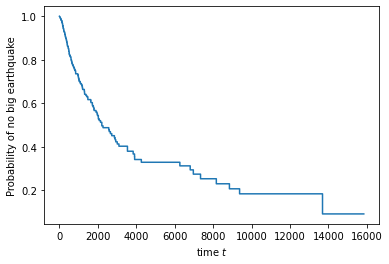

In [23]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(y_array['Status'], y_array['Time_to_event'])
plt.step(time, survival_prob, where='post')
plt.ylabel('Probability of no big earthquake')
plt.xlabel('time $t$')

It looks like most of the big events happened within 4000 days (~11 years) from the previous one. 

Now, for an initial test, let's train a Cox’s proportional hazard’s model and check the concordance index, which is a measure of rank correlation between predicted risk scores and observed time points.

In [24]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [25]:
estimator.score(X_test, y_test)

0.7102963851293472